# Cat Boost Model

## Einleitung

- Yandex is Russian Google
- Yandex uses "gradient boosting" a lot to power their services (music streaming, search, everything really)
- Gradient boosting on decision trees is a form of machine learning that works by progressively training more complex models to maximize the accuracy of predictions. 
- It's particularly useful for predictive models that analyze ordered (continuous) data and categorical data. 
- It's  one of the most efficient ways to build ensemble models. The combination of gradient boosting with decision trees provides state-of-the-art results in many applications with structured data.
- On the first iteration, the algorithm learns the first tree to reduce the training error, shown on left-hand image in figure 1. 
- This model usually has a significant error; it’s not a good idea to build very big trees in boosting since they overfit the data.
- The right-hand image in figure 1 shows the second iteration, in which the algorithm learns one more tree to reduce the error made by the first tree. 
- The algorithm repeats this procedure until it builds a decent quality model

![alt text](https://devblogs.nvidia.com/wp-content/uploads/2018/12/first-second-trees-625x357.png)


- Gradient Boosting is a way to implement this idea for any continuous objective function. 

### Each step of Gradient Boosting combines two steps:

- Step 1 - Computing gradients of the loss function we want to optimize for each input object
- Step 2 - Learning the decision tree which predicts gradients of the loss function

In [1]:
import pandas as pd
import numpy as np
#data visualization
import matplotlib.pyplot as plt
import librosa
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from scipy.stats import kurtosis
from scipy.stats import skew

import seaborn as sns

%matplotlib inline

pd.options.display.precision = 10

## Umgebungsvariablen

In [2]:
#feature generated 24.03.2019
earthquake_daten = '''C:/studium/studium/CAS_PML/Projekt_Arbeit/earthquake/Daten/earthquake_data/'''
feature_62900_94 = 'Features_62900-94.csv'
feature_41934_94 = 'Features_41934_94.csv'
Features_4194_94 = 'Features_4194_94.csv'

# Feature laden

In [52]:
train_data = pd.read_csv(earthquake_daten+feature_41934_94)
train_data = shuffle(train_data, random_state=10)

In [53]:
feature_data = train_data.iloc[:,1:95]
time_to_failure = np.array(train_data.iloc[:,-1])

# Feature Analyse

In [6]:
feature_data.describe()

,mean,std,kurt,skew,min,max,1%q,5%q,25%q,75%q,...,spec_bw_kurt,spec_bw_skew,spec_bw_min,spec_bw_max,spec_bw_1%q,spec_bw_5%q,spec_bw_25%q,spec_bw_75%q,spec_bw_95%q,spec_bw_99%q
count,41934.0000000000,41934.0000000000,41934.0000000000,41934.0000000000,41934.0000000000,41934.0000000000,41934.0000000000,41934.0000000000,41934.0000000000,41934.0000000000,...,41934.0000000000,41934.0000000000,41934.0000000000,41934.0000000000,41934.0000000000,41934.0000000000,41934.0000000000,41934.0000000000,41934.0000000000,41934.0000000000
mean,4.5194207052,6.5494624189,68.3416967641,0.1252057914,-149.3662421901,163.5435923117,-11.2148137549,-2.1890232270,2.2010421138,6.8627605284,...,12.7896841680,-3.1091462491,369580.5488563732,593198.4810650084,417744.4385657278,494608.3722114560,557027.9247439427,578274.0256393899,585354.5354653193,589786.5755651240
std,0.2561034062,8.5039199502,71.5176395737,0.4860815241,266.0096389602,273.7562474249,13.9049955344,2.3700049793,0.5032592236,0.4770053315,...,8.8255001353,0.9061073529,61468.9499724829,3214.8826617986,54932.2573563383,39380.1691725670,15881.1905858769,3704.6218152966,2555.3326193667,2535.7152379601
min,3.5550933333,2.7902372255,0.4321284600,-5.5187945968,-5515.0000000000,23.0000000000,-336.0000000000,-45.0000000000,-3.0000000000,6.0000000000,...,-0.6192454506,-8.7072632508,113489.2027425448,573419.4385050547,122976.6220800366,227892.0518402591,359230.6531110291,517037.1742718818,560509.7559190223,569021.1015906825
25%,4.3517900000,4.4668115189,27.9845548999,-0.0386432786,-155.0000000000,91.0000000000,-14.0000000000,-3.0000000000,2.0000000000,7.0000000000,...,6.9416282271,-3.5548990084,333638.5920621625,591018.0025069662,385736.5493826763,470430.9756211616,549252.2569360731,576065.4411271894,583652.6131847689,588076.5654180326
50%,4.5227633333,5.5939956838,45.5524253052,0.0862328996,-110.0000000000,123.0000000000,-10.0000000000,-2.0000000000,2.0000000000,7.0000000000,...,10.3237286827,-2.9292740624,371274.4264139568,593052.8389875928,419016.2559842028,495585.3611684506,558842.0486257107,578318.5132638491,585350.7299477484,589803.3499884446
75%,4.6929233333,6.8833228272,79.4815017187,0.2564331411,-79.0000000000,170.0000000000,-6.0000000000,-1.0000000000,2.0000000000,7.0000000000,...,15.7958301660,-2.4763579426,410187.1897359705,595212.2423848667,454506.5164036062,523288.3531488007,568587.5202436801,580908.6034652712,587196.4704127871,591519.5543170404
max,5.4638133333,153.7066214235,1986.1592309807,10.5922843032,-15.0000000000,5444.0000000000,-2.0000000000,1.0000000000,3.0000000000,12.0000000000,...,84.4776390813,-0.7233254603,552562.8899506893,613786.0689322522,560062.9325178112,570975.4734872296,578136.8393907149,586966.0075451231,592806.6277031272,598756.1276749838


# Model Workbench

## Imports

In [54]:
# Scaler


# Model selection
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

# Modell
from catboost import CatBoostRegressor, Pool, EFstrType

Quelle: https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

In [55]:
def getMostImportendFeatuers(feat_imp, topAmount):
    '''Gibt die wichtigsten Features zurück. Wird benötigt, um die Trainingsdaten und Testdaten 
    anhand Featuers zu filtern.'''
    i = 0
    featureFilter = list()
    for feature in feat_imp:
        featureFilter.append(feature)
        i +=1
        if i >= topAmount:
            break
    return featureFilter

In [56]:
def modelfit(alg, dtrain, time_to_failure, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain, time_to_failure)
      
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain)

    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, dtrain, time_to_failure, cv=cv_folds, scoring='neg_mean_absolute_error',n_jobs=-1)
    
    #Print model report:
    print("\nModel Report")
    print("MAE train data: %.4g" % mean_absolute_error(time_to_failure, dtrain_predictions)) 
    
    if performCV:
        print("CV Score MAE: \nMean %.7g \nStd %.7g \nMin %.7g \nMax %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, dtrain.columns).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances',figsize=(15,10))
        plt.ylabel('Feature Importance Score')
        plt.show()
        print('Top 20 Feature')
        print(getMostImportendFeatuers(feat_imp.index,20))

# Baseline


Model Report
MAE train data: 1.8
CV Score MAE: 
Mean -1.888768 
Std 0.006188428 
Min -1.897859 
Max -1.879963


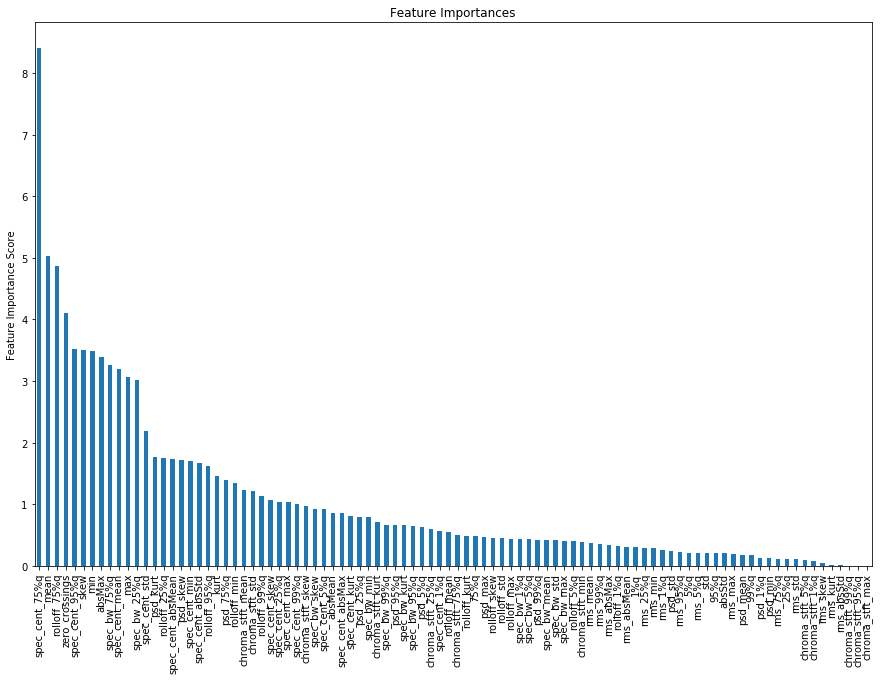

Top 20 Feature
['spec_cent_75%q', 'mean', 'rolloff_75%q', 'zero_crossings', 'spec_cent_95%q', 'skew', 'min', 'absMax', 'spec_bw_75%q', 'spec_cent_mean', 'max', 'spec_bw_25%q', 'spec_cent_std', 'psd_kurt', 'rolloff_25%q', 'spec_cent_absMean', 'psd_skew', 'spec_cent_min', 'spec_cent_absStd', 'rolloff_95%q']


In [8]:
gbm0 = CatBoostRegressor(random_state=10, verbose = False)
modelfit(gbm0, feature_data, time_to_failure)

## Feature Interaction

In [97]:
interactions = gbm0.get_feature_importance(Pool(feature_data,time_to_failure),fstr_type=EFstrType.Interaction, prettified=True)

In [98]:
feature_interaction_df = pd.DataFrame(columns=['feature1', 'feature2', 'interaction_strength'])
for interaction in interactions:
    print(interaction)
    n = list()
    n.append(interaction[0])
    n.append(interaction[1])
    n.append(interaction[2])
    feature_interaction_df = feature_interaction_df.append(n)




('spec_cent_75%q', 8.40299828610723)


IndexError: tuple index out of range

# Model with 20 Features

### Filter Feature
Anhand Feature importence (siehe oben)

In [57]:
# Erhalten aus dem Notebook Model_CatBoost_94
items_to_filter = ['spec_cent_75%q', 'mean', 'rolloff_75%q', 'zero_crossings', 'spec_cent_95%q', 'skew', 'min', 'absMax', 'spec_bw_75%q', 'spec_cent_mean', 'max', 'spec_bw_25%q', 'spec_cent_std', 'psd_kurt', 'rolloff_25%q', 'spec_cent_absMean', 'psd_skew', 'spec_cent_min', 'spec_cent_absStd', 'rolloff_95%q']
filtered_feature_data = feature_data.filter(items=items_to_filter)                 

## Feature Analyse

In [15]:
filtered_feature_data.describe()

,spec_cent_75%q,mean,rolloff_75%q,zero_crossings,spec_cent_95%q,skew,min,absMax,spec_bw_75%q,spec_cent_mean,max,spec_bw_25%q,spec_cent_std,psd_kurt,rolloff_25%q,spec_cent_absMean,psd_skew,spec_cent_min,spec_cent_absStd,rolloff_95%q
count,41934.0000000000,41934.0000000000,4.1934000000e+04,41934.0000000000,41934.0000000000,41934.0000000000,41934.0000000000,41934.0000000000,41934.0000000000,41934.0000000000,41934.0000000000,41934.0000000000,41934.0000000000,41934.0000000000,4.1934000000e+04,41934.0000000000,41934.0000000000,41934.0000000000,41934.0000000000,4.1934000000e+04
mean,742387.2523088438,4.5194207052,1.4689638778e+06,12364.2003386274,766501.4226891467,0.1252057914,-149.3662421901,170.2135260171,578274.0256393899,684110.7118206162,163.5435923117,557027.9247439427,84680.0669979103,21.3592964286,1.3654761519e+06,684110.7118206162,4.3532761010,344798.2757470835,84680.0669979103,1.4987589780e+06
std,20776.6077719682,0.2561034062,2.0638896524e+04,2350.7020123311,12738.7647896970,0.4860815241,266.0096389602,297.8494453362,3704.6218152966,36963.9128289447,273.7562474249,15881.1905858769,17685.2075445529,7.5717075103,7.7640648481e+04,36963.9128289447,0.6992302210,62219.3811823401,17685.2075445529,1.3250882722e+04
min,539282.7949792275,3.5550933333,1.1894531250e+06,5124.0000000000,647020.8741038998,-5.5187945968,-5515.0000000000,23.0000000000,517037.1742718818,446696.5493540333,23.0000000000,359230.6531110291,24103.5421957797,3.9797691222,4.5117187500e+05,446696.5493540333,1.8558664322,163127.6009887653,24103.5421957797,1.3798828125e+06
25%,728775.4999623451,4.3517900000,1.4550781250e+06,10627.0000000000,757997.6752581031,-0.0386432786,-155.0000000000,93.0000000000,576065.4411271894,657968.3689988025,91.0000000000,549252.2569360731,73311.8920516433,15.8853275321,1.3242187500e+06,657968.3689988025,3.8615123630,302540.2457666902,73311.8920516433,1.4902343750e+06
50%,742654.9275670950,4.5227633333,1.4687500000e+06,12508.0000000000,766364.8596778678,0.0862328996,-110.0000000000,127.0000000000,578318.5132638491,681146.7455388771,123.0000000000,558842.0486257107,86503.1387702648,20.3492070936,1.3671875000e+06,681146.7455388771,4.2880156040,339053.1306224105,86503.1387702648,1.4980468750e+06
75%,758660.7690201603,4.6929233333,1.4843750000e+06,14132.0000000000,775932.4720382815,0.2564331411,-79.0000000000,175.0000000000,580908.6034652712,712748.7185540459,170.0000000000,568587.5202436801,96847.1908938453,25.4352391253,1.4218750000e+06,712748.7185540459,4.7566037178,381883.5144340553,96847.1908938453,1.5087890625e+06
max,787634.4965454257,5.4638133333,1.5097656250e+06,19956.0000000000,801471.0921077820,10.5922843032,-15.0000000000,5515.0000000000,586966.0075451231,767270.8528699529,5444.0000000000,578136.8393907149,179844.2450618852,70.4963456266,1.4765625000e+06,767270.8528699529,7.9966616631,633338.5852294917,179844.2450618852,1.5312500000e+06


### Verteilung der einzelnen Features

Text(0.5, 0.98, 'Feature Histogramm')

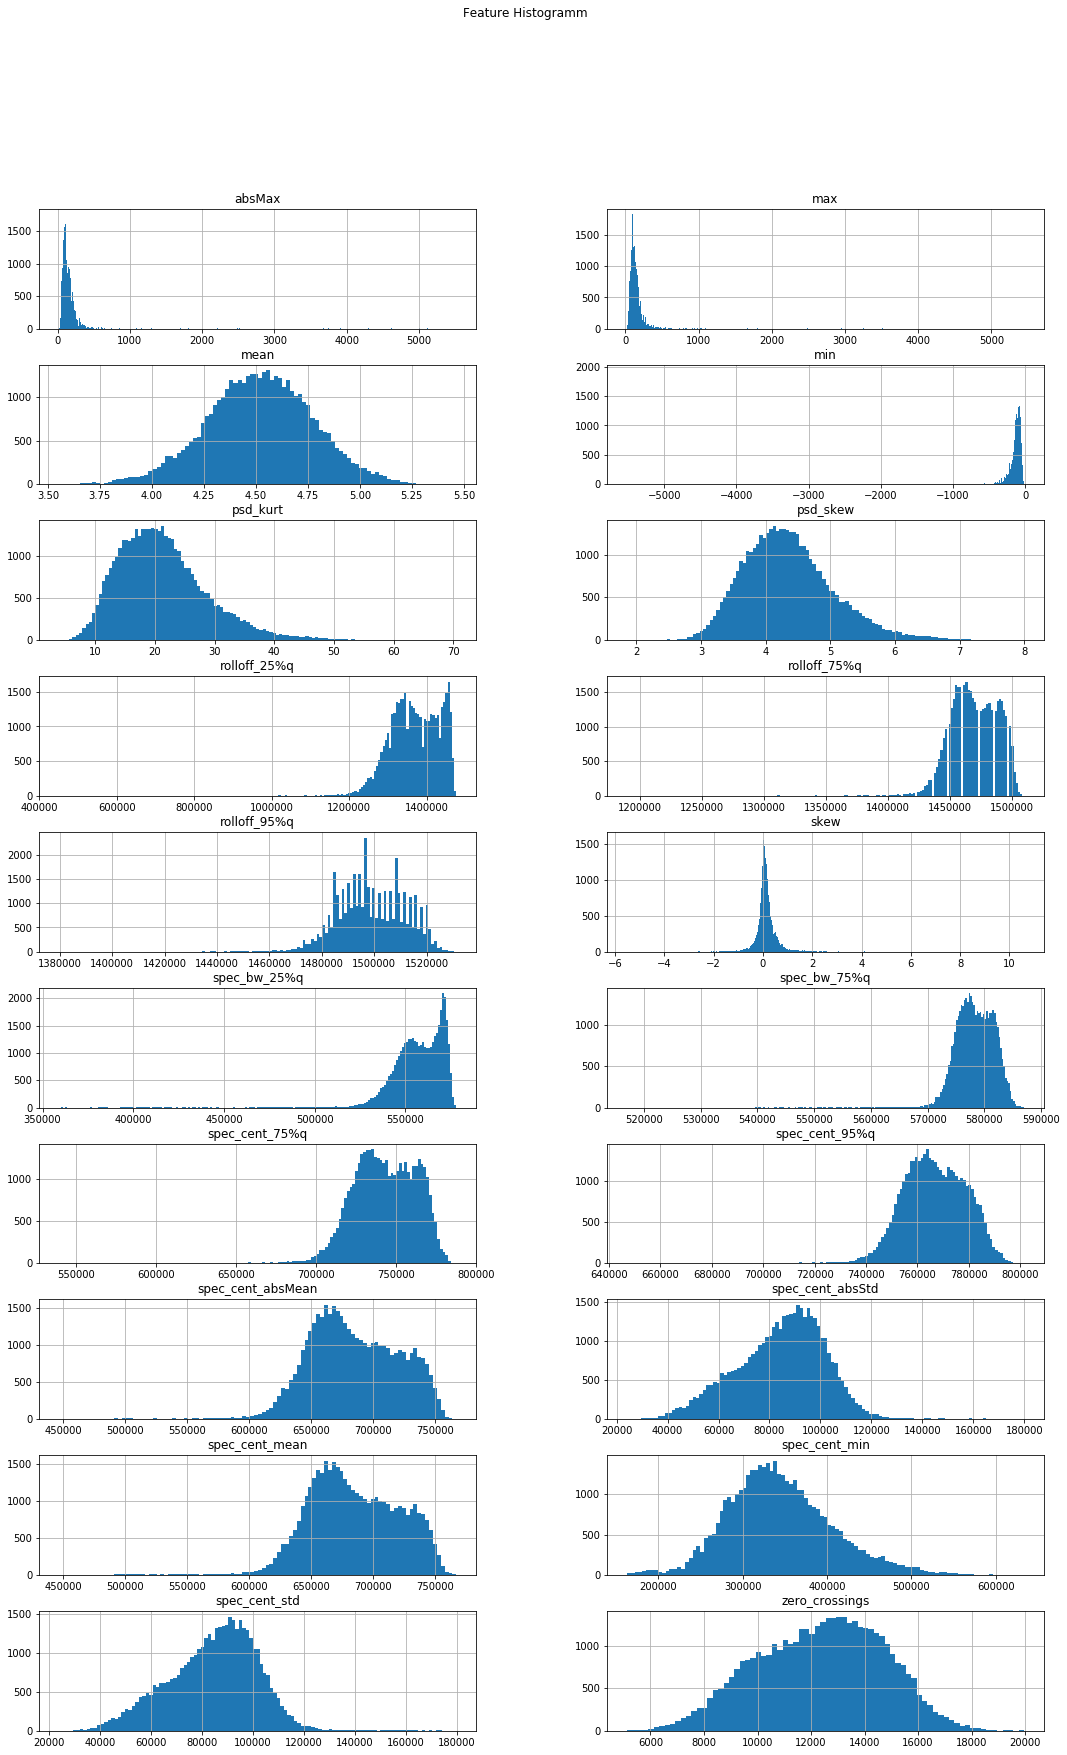

In [6]:
axes = filtered_feature_data.hist(bins='auto', figsize=(18, 28), layout=(10, 2))
plt.suptitle("Feature Histogramm")

### Verteilung von Time_To_Failure

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023073EFB940>]],
      dtype=object)

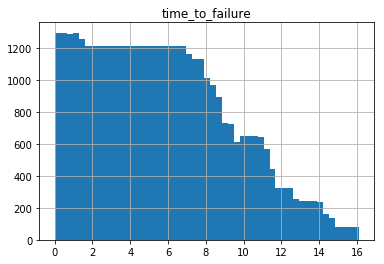

In [9]:
time_to_failure_df = pd.DataFrame(time_to_failure, columns=['time_to_failure'])
time_to_failure_df.hist(bins='auto')

### Korrelationen zwischen den Features

In [19]:
corr = filtered_feature_data.corr()

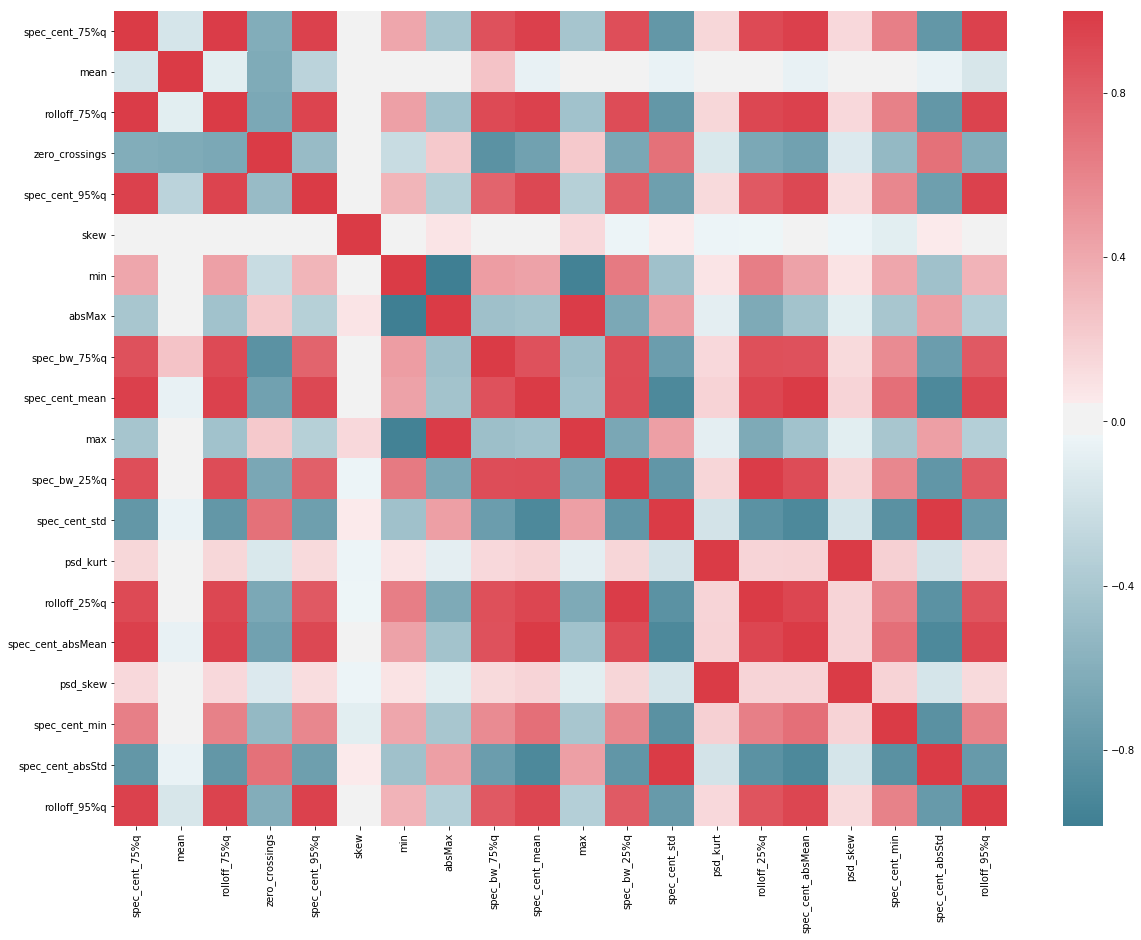

In [20]:
colormap = sns.diverging_palette(220, 10, as_cmap=True)

plt.subplots(figsize=(20,15))
sns.heatmap(corr,cmap=colormap)

# Feature Tuning

(array([1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 3.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 2.000e+00, 1.000e+00, 2.000e+00, 3.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00,
        1.000e+00, 2.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 2.000e+00,
        2.000e+00, 2.000e+00, 2.000e+00, 2.000e+00, 0.000e+00, 1.000e+00,
        2.000e+00, 0.000e+00, 0.000e+0

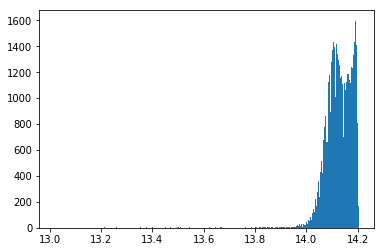

In [66]:
#spec_bw_25%q
plt.hist(np.log(filtered_feature_data['rolloff_25%q']),bins='auto')

### Testen mit Basemodel

In [ ]:
gbm0 = CatBoostRegressor(random_state=10, verbose = False)
modelfit(gbm0, feature_data, time_to_failure)

# Parameter Tuning

 Tune tree based and boosting parameters

### Base Line

In [23]:
gbm0 = CatBoostRegressor(random_state=10, verbose = False)
modelfit(gbm0, filtered_feature_data, time_to_failure,printFeatureImportance=False)


Model Report
MAE train data: 1.8
CV Score MAE: 
Mean -1.879656 
Std 0.005817434 
Min -1.889791 
Max -1.872457


## Importend Parameter

#Quelle: https://effectiveml.com/using-grid-search-to-optimise-catboost-parameters.html#Preventing_Overfitting  
  - iterations=500	The maximum number of trees that can be built when solving machine learning problems. Fewer may be used.
  - learning_rate=0.03	used for reducing the gradient step. It affects the overall time of training: the smaller the value, the more iterations are required for training.
  - depth=6	Depth of the tree. Can be any integer up to 32. Good values in the range 1 - 10.
  - l2_leaf_reg=3	try different values for the regularizer to find the best possible. Any positive values are allowed.
  - loss_function='Logloss'	For 2-class classification use 'LogLoss' or 'CrossEntropy'. For multiclass use 'MultiClass'.
  - border_count=32	The number of splits for numerical features. Allowed values are integers from 1 to 255 inclusively.
  - ctr_border_count=50	The number of splits for categorical features. Allowed values are integers from 1 to 255 inclusively.

In [37]:
train_data = pd.read_csv(earthquake_daten+Features_4194_94)
train_data = shuffle(train_data, random_state=10)


feature_data = train_data.iloc[:,1:95]
time_to_failure_tuning = np.array(train_data.iloc[:,-1])
# Erhalten aus dem Notebook Model_CatBoost_94
items_to_filter = ['spec_cent_75%q', 'mean', 'rolloff_75%q', 'zero_crossings', 'spec_cent_95%q', 'skew', 'min', 'absMax', 'spec_bw_75%q', 'spec_cent_mean', 'max', 'spec_bw_25%q', 'spec_cent_std', 'psd_kurt', 'rolloff_25%q', 'spec_cent_absMean', 'psd_skew', 'spec_cent_min', 'spec_cent_absStd', 'rolloff_95%q']
filtered_feature_data_tuning = feature_data.filter(items=items_to_filter)    

In [46]:
parameters = {'depth':[1,2,3,4,5,6,7,8,9,10],
          'iterations':[250,100,500,1000],
          'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
          'l2_leaf_reg':[3,1,5,10,100],
          'border_count':[32,5,10,20,50,100,200],
          'ctr_border_count':[50,5,10,20,100,200]}

In [67]:
parameters = {'depth':[4,5,6],
          'iterations':[250,100],
          'learning_rate':[0.03,0.01,0.1,0.2], 
          'l2_leaf_reg':[1,3,5,10,100],
          'border_count':[5,10,20,],
          'ctr_border_count':[10,20,100,200]}


In [68]:
#Quelle: https://setscholars.net/2019/02/19/how-to-find-optimal-parameters-for-catboost-using-gridsearchcv-for-regression-in-python/
model = CatBoostRegressor()
                
grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 2, n_jobs=-1)
grid.fit(filtered_feature_data_tuning, time_to_failure_tuning)    

# Results from Grid Search
print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")    
   
print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)
    
print("\n The best score across ALL searched params:\n", grid.best_score_)
    
print("\n The best parameters across ALL searched params:\n", grid.best_params_)
    
print("\n ========================================================")

KeyboardInterrupt: 

train classifier with tuned parameters  

# Save Model

In [ ]:
timestamp = time.time()
#https://catboost.ai/docs/concepts/python-reference_catboost_save_model.html
m.save_model(cat_boost_model+str(timestamp), 
           format="cbm", 
           export_parameters=None,
           pool=None)

 # Model explanation

Quelle: https://github.com/slundberg/shap

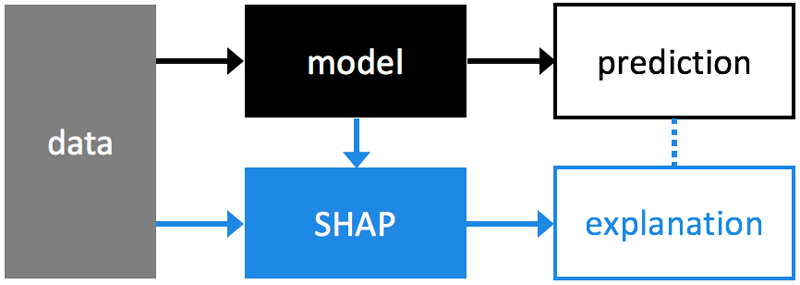